# Train Pneumonia Model using RESNET_34

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
import pandas as pd
import collections
import math

In [3]:
#from load_databunch import build_databunch

In [4]:
import numpy as np
np.random.seed(1234)
import torch
torch.manual_seed(1234)

In [5]:
import fastai_addons   #add plot2 extension -- learn.recorder.plot2()
from fastai_addons import interpretation_summary, plot_confusion_matrix, get_accuracy, \
                          analyze_confidence, accuracy_vs_threshold, show_incremental_accuracy, \
                          analyze_low_confidence, plot_confusion_matrix_thresh

## Config

In [6]:
prefix = 'resnet34_'
selected_model = models.resnet34
bs=96

In [7]:
PATH = Path('')
data_dir = PATH / 'data'
images_full = PATH / 'data' / 'chest_xray'
images_896 = PATH / 'data' / 'chest_xray_896'
images_448 = PATH / 'data' / 'chest_xray_448'
images_224 = PATH / 'data' / 'chest_xray_224'
images_112 = PATH / 'data' / 'chest_xray_112'
images_56 = PATH / 'data' / 'chest_xray_56'

model_dir = PATH / 'models'

# Code

In [8]:
def get_db(image_dir, bs=128, use_test_as_val=True):
    tfms = get_transforms(do_flip=True, flip_vert=False,
                          max_zoom=1.3, max_lighting=0.3)
    if use_test_as_val:
            data = ImageDataBunch.from_folder(image_dir, valid='val', test='test', 
                                      bs=bs, num_workers=7,
                                      ds_tfms=tfms).normalize(imagenet_stats)
    else:
        data = ImageDataBunch.from_folder(image_dir, valid='test', test='val', 
                                          bs=bs, num_workers=7,
                                          ds_tfms=tfms).normalize(imagenet_stats)
    return data

# Calibrate Block Size

In [9]:
for bs in [8, 12, 16, 24, 32]:
    print(f'bs: {bs}')
    data = get_db(images_896, bs)
    learn = cnn_learner(data, selected_model, metrics=error_rate).to_fp16().mixup()
    learn.unfreeze()
    learn.fit(1)

bs: 8


epoch,train_loss,valid_loss,error_rate,time
0,0.550187,1.990423,0.500000,02:51


bs: 12


epoch,train_loss,valid_loss,error_rate,time
0,0.529083,0.672766,0.500000,02:42


bs: 16


epoch,train_loss,valid_loss,error_rate,time
0,0.475023,0.510996,0.375000,02:38


bs: 24


epoch,train_loss,valid_loss,error_rate,time
0,0.437187,1.395841,0.500000,02:38


bs: 32


epoch,train_loss,valid_loss,error_rate,time


RuntimeError: CUDA out of memory. Tried to allocate 54.00 MiB (GPU 0; 11.00 GiB total capacity; 8.22 GiB already allocated; 34.59 MiB free; 155.03 MiB cached)

# Train Model

In [9]:
bs = 24
save_name = f'{prefix}896_frozen'

data = get_db(images_896, bs, use_test_as_val=False)
learn = cnn_learner(data, selected_model, metrics=error_rate).to_fp16().mixup()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-04 
Min loss divided by 10: 6.92E-03
Min numerical gradient: 6.92E-04  (smoothed)
Min numerical gradient: 4.37E-03
Min loss divided by 10: 5.75E-03


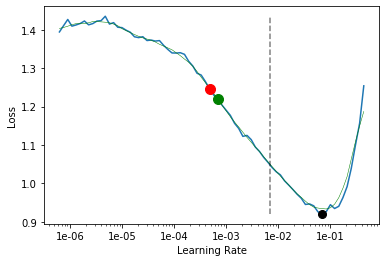

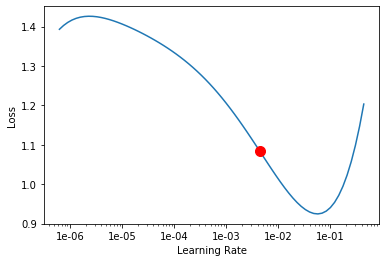

In [10]:
learn.lr_find()
learn.recorder.plot2()
learn.recorder.plot(k=5, suggestion=True)

In [11]:
learn.fit_one_cycle(4, max_lr=1e-3,
                    callbacks=[SaveModelCallback(learn, every='improvement', name=save_name)])

epoch,train_loss,valid_loss,error_rate,time
0,0.457795,0.429821,0.173077,02:48
1,0.313276,0.360465,0.141026,02:49
2,0.287477,0.420839,0.165064,02:48
3,0.278907,0.427348,0.161859,02:49


Better model found at epoch 0 with valid_loss value: 0.42982134222984314.
Better model found at epoch 1 with valid_loss value: 0.3604647219181061.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07 
Min loss divided by 10: 2.75E-07
Min numerical gradient: 1.10E-06  (smoothed)
Min numerical gradient: 6.92E-06
Min loss divided by 10: 6.31E-08


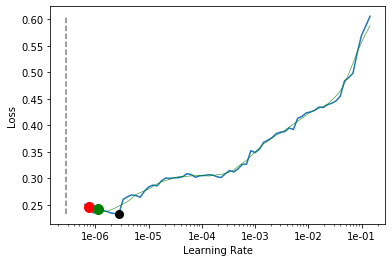

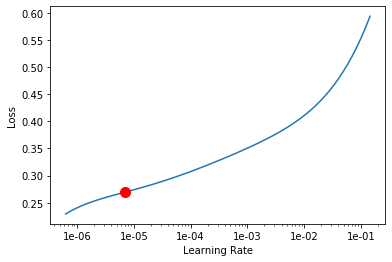

In [13]:
save_name = f'{prefix}896_unfrozen'
learn.unfreeze()

learn.lr_find()
learn.recorder.plot2()
learn.recorder.plot(k=5, suggestion=True)

In [15]:
learn.fit_one_cycle(4, max_lr=slice(3e-5),
                    callbacks=[SaveModelCallback(learn, every='improvement', name=save_name)])

epoch,train_loss,valid_loss,error_rate,time
0,0.307995,0.588027,0.245192,02:52
1,0.289471,0.526467,0.208333,02:52
2,0.281614,0.412859,0.160256,02:51
3,0.277230,0.434254,0.166667,02:52


Better model found at epoch 0 with valid_loss value: 0.5880270004272461.
Better model found at epoch 1 with valid_loss value: 0.5264667868614197.
Better model found at epoch 2 with valid_loss value: 0.41285887360572815.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06 
Min loss divided by 10: 6.31E-08
Min numerical gradient: 1.74E-05  (smoothed)
Min numerical gradient: 8.32E-06
Min loss divided by 10: 6.31E-08


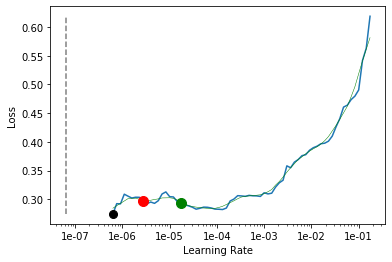

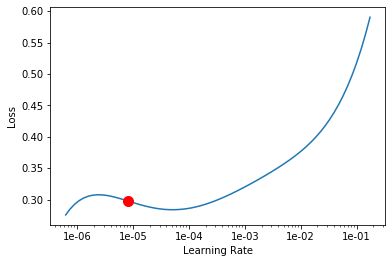

In [16]:
learn.lr_find()
learn.recorder.plot2()
learn.recorder.plot(k=5, suggestion=True)

In [17]:
learn.fit_one_cycle(32, max_lr=slice(3e-5),
                    callbacks=[SaveModelCallback(learn, every='improvement', name=save_name)])

epoch,train_loss,valid_loss,error_rate,time
0,0.275940,0.502945,0.197115,02:51
1,0.293062,0.448433,0.173077,02:51
2,0.265645,0.384784,0.145833,02:52
3,0.279004,0.446359,0.176282,02:52
4,0.280120,0.450037,0.165064,02:50
5,0.270711,0.370522,0.136218,02:52
6,0.259446,0.372771,0.139423,02:51
7,0.265125,0.332274,0.112179,02:49
8,0.248270,0.390117,0.144231,02:51
9,0.249877,0.413534,0.149038,02:51


Better model found at epoch 0 with valid_loss value: 0.502945065498352.
Better model found at epoch 1 with valid_loss value: 0.4484330117702484.
Better model found at epoch 2 with valid_loss value: 0.3847842216491699.
Better model found at epoch 5 with valid_loss value: 0.37052208185195923.
Better model found at epoch 7 with valid_loss value: 0.3322743773460388.
Better model found at epoch 24 with valid_loss value: 0.32539960741996765.
